In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

sess = tf.compat.v1.Session()


# 1.도형 인식 데이터셋 구성하기

In [26]:
#1
x_data = []
y_data = []

im = 100

for i in range(50) :
    img = Image.open(('gadata/geaam%d.jpg') % (i+1))
    rgb = img.convert('RGB').resize((im, im)) 
    data = np.array( rgb, dtype='uint8' )    
    x_data.append(  data.flatten()   )
    y_data.append(0) 
    
for i in range(54) :
    img = Image.open(('nodata/%d.jpg') % (i+1))
    rgb = img.convert('RGB').resize((im, im))    
    data = np.array( rgb, dtype='uint8' )    
    x_data.append(  data.flatten()   )
    y_data.append(1)
    #독버섯 = 1
    
x_data = np.array(x_data) / 255.0
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)
print(y_data.shape[0])

(104, 30000)
(104,)
104


In [27]:

def one_hot(y, nclass) :
    r = y.shape[0]
    mat = np.zeros([r, nclass])
    for i in range(r) :
        mat[i, int(y[i])] = 1        
    return mat

y_data_onehot = one_hot(y_data, 2)
print(y_data.shape)
print(y_data[0:5])
print(y_data_onehot.shape)
print(y_data_onehot[0:5, :])
print(x_data[0])
print(x_data[0].shape)

(104,)
[0 0 0 0 0]
(104, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[0.14117647 0.16078431 0.12941176 ... 0.49803922 0.52941176 0.43137255]
(30000,)


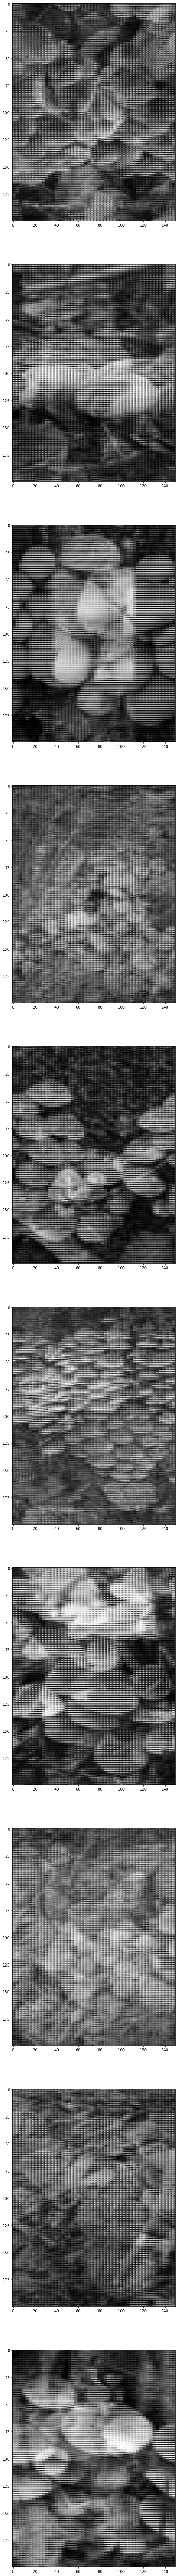

In [28]:

imhor = 200
imver = 150

plt.figure(figsize=(imhor,imver)) 
for i  in range(10) :
    plt.subplot(12, 1, i+1) 
    plt.imshow(x_data[i,:].reshape(imhor,imver), cmap='gray') 
                                                          

In [29]:
#4

def split(x_data, y_data, rate) :
    n = x_data.shape[0] 
    print(n)
    arr = np.arange(n)   
    np.random.shuffle(arr) 

    n0 = int(n * rate) 
    x_train = x_data[arr[0:n0], :]
    y_train = y_data[arr[0:n0], :]
    x_test =  x_data[arr[n0:], :]
    y_test =  y_data[arr[n0::], :]
    
    return (x_train, y_train, x_test, y_test)

x_train, y_train, x_test, y_test = split(x_data, y_data_onehot, 0.9)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

104
(93, 30000) (93, 2)
(11, 30000) (11, 2)


# 2. 도형인식을 위한 컨볼루션 신경망

In [30]:
#1
tf.compat.v1.disable_eager_execution() 
nclass = 2 
dim = imhor*imver 
nfilter = 32
nhidden = 300

x = tf.compat.v1.placeholder("float", shape=[None, dim])
y = tf.compat.v1.placeholder("float", shape=[None, nclass])

x_image = tf.reshape(x, [-1,200,150,1]) 

In [31]:
#2
filter = tf.Variable(tf.compat.v1.random_normal([3, 3, 1, nfilter], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[nfilter]))
conv = tf.nn.sigmoid(tf.nn.conv2d(x_image, filter, strides=[1, 1, 1, 1], padding='SAME') + b)
print(conv.shape)

(None, 200, 150, 32)


In [32]:

pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool.shape)

(None, 100, 75, 32)


In [33]:

h_flat = tf.reshape(pool, [-1, int(imhor/2) * int(imver/2) * nfilter])


w_fc = tf.Variable(tf.compat.v1.random_normal([int(imhor/2) * int(imver/2) * nfilter, nhidden], stddev=0.1))   #1250
b_fc = tf.Variable(tf.constant(0.1, shape=[nhidden]))

h_fc = tf.sigmoid(tf.matmul(h_flat, w_fc) + b_fc)

print(pool.shape)
print(h_flat.shape)
print(w_fc.shape)
print(h_fc.shape)

(None, 100, 75, 32)
(None, 240000)
(240000, 300)
(None, 300)


In [34]:
#5
w_out = tf.Variable(tf.compat.v1.random_normal([nhidden, nclass], stddev=0.1))
b_out = tf.Variable(tf.constant(0.1, shape=[nclass]))

logits = tf.matmul(h_fc, w_out) + b_out

print(w_out.shape)
print(logits.shape)

(300, 2)
(None, 2)


In [35]:
#6
hypothesis = tf.nn.softmax(logits)

cost = -tf.compat.v1.reduce_mean(y*tf.compat.v1.log(hypothesis))
update = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(cost)

    

predicted = tf.argmax(hypothesis, 1)

accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(y, 1)), tf.float32))

In [36]:
#7
print(filter.shape)
print(b.shape)
print(w_fc.shape)
print(b_fc.shape)
print(w_out.shape)
print(b_out.shape)

(3, 3, 1, 32)
(32,)
(240000, 300)
(300,)
(300, 2)
(2,)


# 3. 함수로 정리하기

In [38]:
#8
sess.run(tf.compat.v1.global_variables_initializer())

for i in range(6001) :    
    sess.run(update,feed_dict={x: x_train, y: y_train})
    
    if i %300 ==0 :
        a, c = sess.run([accuracy, cost], feed_dict= {x:x_train, y:y_train})
        print(i, "train : ",  a, c) 
    
at, ct = sess.run([accuracy, cost], feed_dict={ x:x_test, y: y_test})
print("test : ",  at, ct) 

0 train :  0.47311828 1.5390369
300 train :  0.47311828 0.6964679
600 train :  0.47311828 0.686614
900 train :  0.47311828 0.679567
1200 train :  0.47311828 0.6679727
1500 train :  0.47311828 0.65146697
1800 train :  0.47311828 0.6426683
2100 train :  0.47311828 0.63782513
2400 train :  0.47311828 0.6284113
2700 train :  0.47311828 0.6239244
3000 train :  0.47311828 0.6202693
3300 train :  0.47311828 0.6184991
3600 train :  0.47311828 0.6179843
3900 train :  0.47311828 0.61065286
4200 train :  0.47311828 0.6061455
4500 train :  0.48387095 0.60449314
4800 train :  0.48387095 0.60114425
5100 train :  0.48387095 0.6010965
5400 train :  0.48387095 0.5640371
5700 train :  0.48387095 0.5852622
6000 train :  0.5913978 0.47230783
test :  0.6363636 0.42816895


In [40]:
#1
atr,ctr = sess.run([accuracy, cost], feed_dict= {x:x_train, y:y_train})
print("acc :",atr)
def convolutionLayer(input, nfilter, sfilter) :
    
    size = input.shape.as_list() 
    nhidden = size[3]       
    
    filter = tf.Variable(tf.random_normal([sfilter, sfilter, nhidden, nfilter], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[nfilter]))
    conv = tf.nn.sigmoid(tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME') + b)
    pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
    return pool

acc : 0.5913978


In [ ]:
#2
def neuralnetworkLayer(pool, nhidden) :
    
    size = pool.shape.as_list()    
    flatten =  size[1] *  size[2] * size[3]
    
    h_flatten = tf.reshape(pool, [-1, flatten])
    
    w_fc = tf.Variable(tf.random_normal([flatten, nhidden], stddev=0.1))
    b_fc = tf.Variable(tf.constant(0.1, shape=[nhidden]))
    
    h_fc = tf.nn.sigmoid(tf.matmul(h_flatten, w_fc) + b_fc)
    
    
    return  h_fc    

In [ ]:
#3    
def outputLayer(h_fc, nclass) :            
    size = h_fc.shape.as_list()        
    nhidden = size[1]
    w_fc = tf.Variable(tf.random_normal([nhidden, nclass], stddev=0.1))
    b_fc = tf.Variable(tf.constant(0.1, shape=[nclass]))
    logits = tf.matmul(h_fc, w_fc) + b_fc
    return  logits

In [ ]:
#4
pool = convolutionLayer(x_image, 32, 3)
hidden = neuralnetworkLayer(pool, 300)
logits = outputLayer(hidden, 3)

print(x_image.shape)
print(pool.shape)
print(hidden.shape)
print(logits.shape)

In [ ]:
#5
hypothesis = tf.nn.softmax(logits)

cost = -tf.reduce_mean(y*tf.log(hypothesis))
update = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

predicted = tf.argmax(hypothesis, 1)

accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(y, 1)), tf.float32))

sess.run(tf.global_variables_initializer())

for i in range(6001) :    
    sess.run(update,feed_dict={x: x_train, y: y_train})
    
    if i % 300 == 0 :
        a, c = sess.run([accuracy, cost], feed_dict={ x:x_test, y: y_test})
        print(i, "test : ",  a, c)    
a = sess.run(accuracy, feed_dict={ x:x_train, y: y_train})     
print(a)

# 4. 다층 구조로 일반화 시키기

In [ ]:
#1
def neuralnetworkLayer2(hidden, nhidden) :  #from 1d  to 1d
    
    size = hidden.shape.as_list()        
    prehidden = size[1]
    
    w_fc = tf.Variable(tf.random_normal([prehidden, nhidden], stddev=0.1))
    b_fc = tf.Variable(tf.constant(0.1, shape=[nhidden]))
    h_fc = tf.nn.sigmoid(tf.matmul(hidden, w_fc) + b_fc)
    return  h_fc    
    
    

In [ ]:
#2
pool = convolutionLayer(x_image, 32,3 )
pool2 = convolutionLayer(pool, 64,3 )
hidden  = neuralnetworkLayer(pool2, 300)
hidden2  = neuralnetworkLayer2(hidden, 100)
logits = outputLayer(hidden2, 3)


print(x_image.shape)
print(pool.shape)
print(pool2.shape)
print(hidden.shape)
print(hidden2.shape)
print(logits.shape)

In [ ]:
#3
hypothesis = tf.nn.softmax(logits)

cost = -tf.reduce_mean(y*tf.log(hypothesis))
update = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

predicted = tf.argmax(hypothesis, 1)

accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(y, 1)), tf.float32))

sess.run(tf.global_variables_initializer())

for i in range(3001) :    
    sess.run(update,feed_dict={x: x_train, y: y_train})
    
    if i % 300 == 0 :
        a, c = sess.run([accuracy, cost], feed_dict={ x:x_test, y: y_test})
        print(i, "test : ",  a, c)    
a = sess.run(accuracy, feed_dict={ x:x_train, y: y_train})     
print(a)

# 5. 결과 분석하기

In [ ]:
#1
h, p = sess.run([hypothesis, predicted], feed_dict={ x:x_test, y: y_test})   

labels = ['S', 'T', 'C']
y_data2 = np.argmax(y_test, axis=1)

print(h.shape)
print(p.shape)
print(y_data2.shape)

In [ ]:
    
plt.figure(figsize=(20, 25))

for i in range(24) :        
  plt.subplot(6, 4*2, i*2+1)
  plt.imshow(x_test[i,:].reshape(im,im), cmap='gray')    
  c =  "blue" if  p[i] == y_data2[i]   else "red"    
  plt.subplot(6, 4*2, i*2+2)
  plt.bar(labels, h[i], color=c)
  plt.xlabel("{}-> {} {:2.0f}%".format(labels[int(y_data2[  i ])], labels[p[  i ]],        100*np.max(h[i], axis=0)),  color = c )   
    